In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import cbook

In [3]:
#ML_MODELS = 10           #number of models
EPOCHS = 40    #number of iterations
ETL_JOBS = 100            #number of ETL jobs
TIME_COST_HOUR = np.arange(0,3,0.01)    #Cost of wait per hour, we assume linear wait time
BATCH_PER_EPOCH = 16000

In [4]:
#Line colors in matplotlib
C5D_COLOR = 0.1
M5D_COLOR = 0.2
R5D_COLOR = 0.9
G3S_COLOR = 0.75
G5_COLOR = 0.5

In [5]:
data_prep_results = pd.read_excel('experiment_results/data_prep_experiment_results.xlsx', sheet_name = "Data_Preparation", index_col="No")


In [6]:
cost_optimal_results = pd.read_excel('experiment_results/cost_optimal_estimates.xlsx', sheet_name = "Sheet1")

In [7]:
cost_optimal_results = cost_optimal_results.set_index("Unnamed: 0")

In [8]:
#data_extract_results = data_prep_results.loc[:10,["Compute","Time (s)", "Cost"]]
data_prep_results_averages = data_prep_results.groupby(['Experiment','Compute']).mean(numeric_only = True)
data_prep_results_averages["Total_Cost"] = data_prep_results_averages["Time (s)"]*data_prep_results_averages["Cost"]/3600

In [9]:
data_prep_results_averages["Est_time"] = 0

In [10]:
data_prep_results_averages.loc[("Data Extract From S3 and partition","c5d.2xlarge"),"Est_time"] = \
cost_optimal_results.loc[("c5d.2xlarge"),"Data_extract_est"]
data_prep_results_averages.loc[("Data Extract From S3 and partition","m5d.xlarge"),"Est_time"] = \
cost_optimal_results.loc[("m5d.xlarge"),"Data_extract_est"]
data_prep_results_averages.loc[("Data Extract From S3 and partition","r5d.xlarge"),"Est_time"] = \
cost_optimal_results.loc[("r5d.xlarge"),"Data_extract_est"]

In [11]:
data_prep_results_averages.loc[("Data Joins and Load to S3","c5d.2xlarge"),"Est_time"] = \
cost_optimal_results.loc[("c5d.2xlarge"),"Data_joins_est"]
data_prep_results_averages.loc[("Data Joins and Load to S3","m5d.xlarge"),"Est_time"] = \
cost_optimal_results.loc[("m5d.xlarge"),"Data_joins_est"]
data_prep_results_averages.loc[("Data Joins and Load to S3","r5d.xlarge"),"Est_time"] = \
cost_optimal_results.loc[("r5d.xlarge"),"Data_joins_est"]

In [12]:
data_prep_results_averages = data_prep_results_averages.reset_index()

In [13]:
data_extract_results_averages=data_prep_results_averages.loc[:2,["Compute","Time (s)","Est_time","Total_Cost"]].set_index("Compute")

In [14]:
data_join_results_averages=data_prep_results_averages.loc[3:,["Compute","Time (s)","Est_time","Total_Cost"]].set_index("Compute")

In [15]:
DATA_EXTRACT_TOTAL_COST_C5D = (data_extract_results_averages.loc["c5d.2xlarge","Total_Cost"]
                               +(data_extract_results_averages.loc["c5d.2xlarge","Time (s)"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_EXTRACT_TOTAL_COST_M5D = (data_extract_results_averages.loc["m5d.xlarge","Total_Cost"]
                               +(data_extract_results_averages.loc["m5d.xlarge","Time (s)"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_EXTRACT_TOTAL_COST_R5D = (data_extract_results_averages.loc["r5d.xlarge","Total_Cost"]
                               +(data_extract_results_averages.loc["r5d.xlarge","Time (s)"]/3600)*TIME_COST_HOUR)*ETL_JOBS


In [16]:
idx = np.argwhere(np.diff(np.sign(DATA_EXTRACT_TOTAL_COST_C5D-DATA_EXTRACT_TOTAL_COST_M5D))).flatten()
intersect_x , intersect_y = TIME_COST_HOUR[idx],DATA_EXTRACT_TOTAL_COST_C5D[idx]

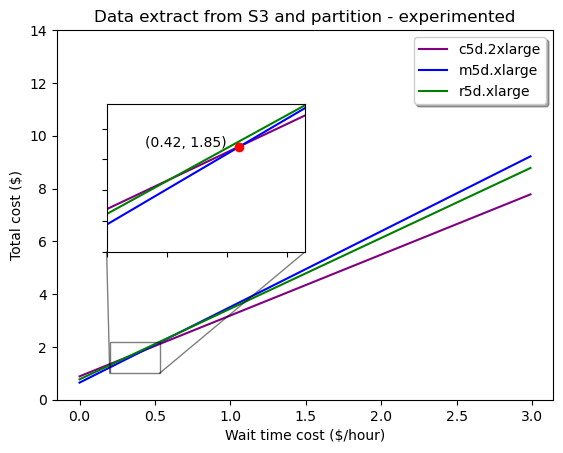

In [17]:
fig, ax = plt.subplots()
ax.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_C5D, label = "c5d.2xlarge", color= "purple")
ax.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_M5D, label = "m5d.xlarge", color = "blue")
ax.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_R5D, label = "r5d.xlarge", color= "green")

x1, x2, y1, y2 = 0.2, 0.53, 1 , 2.2  # subregion of the original image

axins = ax.inset_axes(
    [0.1, 0.4, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_C5D, label = "c5d.2xlarge", color= "purple")
axins.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_M5D, label = "m5d.xlarge", color = "blue")
axins.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_R5D, label = "r5d.xlarge", color= "green")
axins.plot(intersect_x , intersect_y,'ro')
axins.text(intersect_x-0.02 , intersect_y, f'({intersect_x[0]}, {np.round(intersect_y[0],2)})', ha='right')

ax.indicate_inset_zoom(axins, edgecolor="black")



legend = ax.legend(loc='upper right', shadow=True)

plt.title('Data extract from S3 and partition - execution')
plt.xlabel('Wait time cost ($/hour)')
plt.ylabel('Total cost ($)')
plt.ylim(0,14)
plt.savefig("data_extract.png")
plt.show()

In [18]:
DATA_EXTRACT_TOTAL_COST_C5D_EST = (data_extract_results_averages.loc["c5d.2xlarge","Total_Cost"]
                               +(data_extract_results_averages.loc["c5d.2xlarge","Est_time"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_EXTRACT_TOTAL_COST_M5D_EST = (data_extract_results_averages.loc["m5d.xlarge","Total_Cost"]
                               +(data_extract_results_averages.loc["m5d.xlarge","Est_time"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_EXTRACT_TOTAL_COST_R5D_EST = (data_extract_results_averages.loc["r5d.xlarge","Total_Cost"]
                               +(data_extract_results_averages.loc["r5d.xlarge","Est_time"]/3600)*TIME_COST_HOUR)*ETL_JOBS

In [19]:
idx = np.argwhere(np.diff(np.sign(DATA_EXTRACT_TOTAL_COST_C5D_EST - DATA_EXTRACT_TOTAL_COST_M5D_EST))).flatten()
intersect_x , intersect_y = TIME_COST_HOUR[idx],DATA_EXTRACT_TOTAL_COST_C5D_EST[idx]

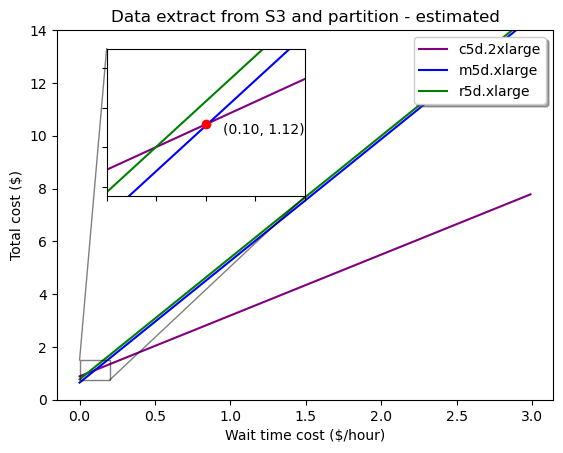

In [20]:
fig, ax = plt.subplots()
ax.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_C5D_EST, label = "c5d.2xlarge", color= "purple")
ax.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_M5D_EST, label = "m5d.xlarge", color = "blue")
ax.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_R5D_EST, label = "r5d.xlarge", color= "green")
x1, x2, y1, y2 = 0, 0.2, 0.75 , 1.5  # subregion of the original image

axins = ax.inset_axes(
    [0.1, 0.55, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_C5D_EST, label = "c5d.2xlarge", color= "purple")
axins.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_M5D_EST, label = "m5d.xlarge", color = "blue")
axins.plot(TIME_COST_HOUR,DATA_EXTRACT_TOTAL_COST_R5D_EST, label = "r5d.xlarge", color= "green")
axins.plot(intersect_x , intersect_y,'ro')
axins.text(intersect_x+0.1, intersect_y-0.05, f'({intersect_x[0]:.2f}, {np.round(intersect_y[0],2)})', ha='right')

ax.indicate_inset_zoom(axins, edgecolor="black")

legend = ax.legend(loc='upper right', shadow=True)

plt.title('Data extract from S3 and partition - estimation')
plt.xlabel('Wait time cost ($/hour)')
plt.ylabel('Total cost ($)')
plt.ylim(0,14)
plt.savefig("data_extract_est.png")
plt.show()

In [21]:
DATA_EXTRACT_CHEAPEST = np.full(TIME_COST_HOUR.shape,None)
DATA_EXTRACT_CHEAPEST_EST = np.full(TIME_COST_HOUR.shape,None)

In [22]:
for i in np.arange(len(DATA_EXTRACT_CHEAPEST)):
    if (DATA_EXTRACT_TOTAL_COST_C5D[i] < DATA_EXTRACT_TOTAL_COST_M5D[i]) and (DATA_EXTRACT_TOTAL_COST_C5D[i] < DATA_EXTRACT_TOTAL_COST_R5D[i]):
        DATA_EXTRACT_CHEAPEST[i] = C5D_COLOR
    elif (DATA_EXTRACT_TOTAL_COST_M5D[i] < DATA_EXTRACT_TOTAL_COST_C5D[i]) and (DATA_EXTRACT_TOTAL_COST_M5D[i] < DATA_EXTRACT_TOTAL_COST_R5D[i]):
        DATA_EXTRACT_CHEAPEST[i] = M5D_COLOR
    else:
        DATA_EXTRACT_CHEAPEST[i] = R5D_COLOR
    

In [23]:
for i in np.arange(len(DATA_EXTRACT_CHEAPEST_EST)):
    if (DATA_EXTRACT_TOTAL_COST_C5D_EST[i] < DATA_EXTRACT_TOTAL_COST_M5D_EST[i]) and (DATA_EXTRACT_TOTAL_COST_C5D_EST[i] < DATA_EXTRACT_TOTAL_COST_R5D_EST[i]):
        DATA_EXTRACT_CHEAPEST_EST[i] = C5D_COLOR
    elif (DATA_EXTRACT_TOTAL_COST_M5D_EST[i] < DATA_EXTRACT_TOTAL_COST_C5D_EST[i]) and (DATA_EXTRACT_TOTAL_COST_M5D_EST[i] < DATA_EXTRACT_TOTAL_COST_R5D_EST[i]):
        DATA_EXTRACT_CHEAPEST_EST[i] = M5D_COLOR
    else:
        DATA_EXTRACT_CHEAPEST_EST[i] = R5D_COLOR
    

In [24]:
DATA_JOINS_TOTAL_COST_C5D = (data_join_results_averages.loc["c5d.2xlarge","Total_Cost"] 
                             +(data_join_results_averages.loc["c5d.2xlarge","Time (s)"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_JOINS_TOTAL_COST_M5D = (data_join_results_averages.loc["m5d.xlarge","Total_Cost"] 
                             +(data_join_results_averages.loc["m5d.xlarge","Time (s)"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_JOINS_TOTAL_COST_R5D = (data_join_results_averages.loc["r5d.xlarge","Total_Cost"]
                             +(data_join_results_averages.loc["r5d.xlarge","Time (s)"]/3600)*TIME_COST_HOUR)*ETL_JOBS


In [25]:
idx = np.argwhere(np.diff(np.sign(DATA_JOINS_TOTAL_COST_R5D - DATA_JOINS_TOTAL_COST_M5D))).flatten()
intersect_x , intersect_y = TIME_COST_HOUR[idx],DATA_JOINS_TOTAL_COST_R5D[idx]

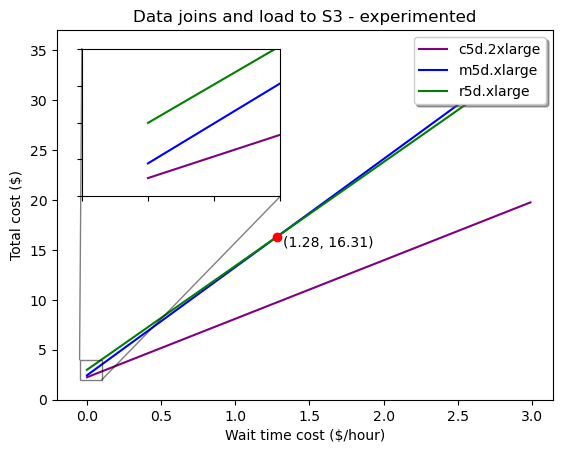

In [26]:
fig, ax = plt.subplots()
ax.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_C5D, label = "c5d.2xlarge", color= "purple")
ax.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_M5D, label = "m5d.xlarge", color = "blue")
ax.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_R5D, label = "r5d.xlarge", color = "green")
ax.plot(intersect_x , intersect_y,'ro')
ax.text(intersect_x+0.65, intersect_y-1, f'({intersect_x[0]:.2f}, {intersect_y[0]:.2f})', ha='right')

x1, x2, y1, y2 = -0.05, 0.1, 2 , 4  # subregion of the original image

axins = ax.inset_axes(
    [0.05, 0.55, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_C5D, label = "c5d.2xlarge", color= "purple")
axins.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_M5D, label = "m5d.xlarge", color = "blue")
axins.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_R5D, label = "r5d.xlarge", color= "green")

ax.indicate_inset_zoom(axins, edgecolor="black")

legend = ax.legend(loc='upper right', shadow=True)

plt.title('Data joins and load to S3 - execution')
plt.xlabel('Wait time cost ($/hour)')
plt.ylabel('Total cost ($)')
plt.ylim(0,37)
plt.savefig("data_joins.png")
plt.show()

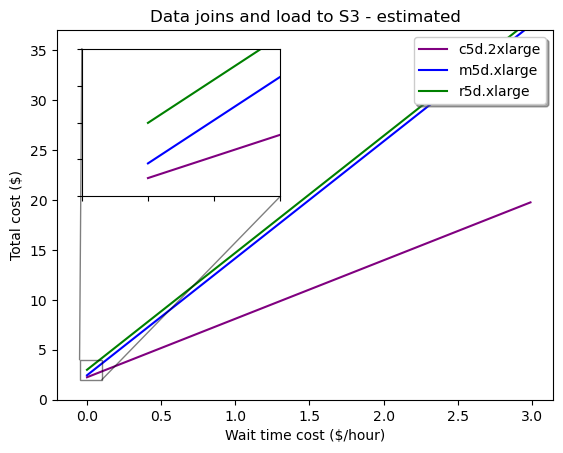

In [27]:
DATA_JOINS_TOTAL_COST_C5D_EST = (data_join_results_averages.loc["c5d.2xlarge","Total_Cost"] 
                             +(data_join_results_averages.loc["c5d.2xlarge","Est_time"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_JOINS_TOTAL_COST_M5D_EST = (data_join_results_averages.loc["m5d.xlarge","Total_Cost"] 
                             +(data_join_results_averages.loc["m5d.xlarge","Est_time"]/3600)*TIME_COST_HOUR)*ETL_JOBS

DATA_JOINS_TOTAL_COST_R5D_EST = (data_join_results_averages.loc["r5d.xlarge","Total_Cost"]
                             +(data_join_results_averages.loc["r5d.xlarge","Est_time"]/3600)*TIME_COST_HOUR)*ETL_JOBS

fig, ax = plt.subplots()
ax.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_C5D_EST, label = "c5d.2xlarge", color= "purple")
ax.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_M5D_EST, label = "m5d.xlarge", color = "blue")
ax.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_R5D_EST, label = "r5d.xlarge", color = "green")

x1, x2, y1, y2 = -0.05, 0.1, 2 , 4  # subregion of the original image

axins = ax.inset_axes(
    [0.05, 0.55, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_C5D_EST, label = "c5d.2xlarge", color= "purple")
axins.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_M5D_EST, label = "m5d.xlarge", color = "blue")
axins.plot(TIME_COST_HOUR,DATA_JOINS_TOTAL_COST_R5D_EST, label = "r5d.xlarge", color= "green")

ax.indicate_inset_zoom(axins, edgecolor="black")

legend = ax.legend(loc='upper right', shadow=True)

plt.title('Data joins and load to S3 - estimation')
plt.xlabel('Wait time cost ($/hour)')
plt.ylabel('Total cost ($)')
plt.ylim(0,37)
plt.savefig("data_joins_est.png")
plt.show()

In [28]:
DATA_JOINS_CHEAPEST = np.full(TIME_COST_HOUR.shape,None)
DATA_JOINS_CHEAPEST_EST = np.full(TIME_COST_HOUR.shape,None)

In [29]:
for i in np.arange(len(DATA_JOINS_CHEAPEST)):
    if (DATA_JOINS_TOTAL_COST_C5D[i] < DATA_JOINS_TOTAL_COST_M5D[i]) and (DATA_JOINS_TOTAL_COST_C5D[i] < DATA_JOINS_TOTAL_COST_R5D[i]):
        DATA_JOINS_CHEAPEST[i] = C5D_COLOR
    elif (DATA_JOINS_TOTAL_COST_M5D[i] < DATA_JOINS_TOTAL_COST_C5D[i]) and (DATA_JOINS_TOTAL_COST_M5D[i] < DATA_JOINS_TOTAL_COST_R5D[i]):
        DATA_JOINS_CHEAPEST[i] = M5D_COLOR
    else:
        DATA_JOINS_CHEAPEST[i] = R5D_COLOR

In [30]:
for i in np.arange(len(DATA_JOINS_CHEAPEST_EST)):
    if (DATA_JOINS_TOTAL_COST_C5D_EST[i] < DATA_JOINS_TOTAL_COST_M5D_EST[i]) and (DATA_JOINS_TOTAL_COST_C5D_EST[i] < DATA_JOINS_TOTAL_COST_R5D_EST[i]):
        DATA_JOINS_CHEAPEST_EST[i] = C5D_COLOR
    elif (DATA_JOINS_TOTAL_COST_M5D_EST[i] < DATA_JOINS_TOTAL_COST_C5D_EST[i]) and (DATA_JOINS_TOTAL_COST_M5D_EST[i] < DATA_JOINS_TOTAL_COST_R5D_EST[i]):
        DATA_JOINS_CHEAPEST_EST[i] = M5D_COLOR
    else:
        DATA_JOINS_CHEAPEST_EST[i] = R5D_COLOR

In [31]:
ML_training_results = pd.read_excel('experiment_results/ML_Training_Results.xlsx', sheet_name = "ML_Training_Results")

In [32]:
ML_training_results = ML_training_results.loc[3:,['EC2 instance','Execution time (ms)','PALEO estimation (ms)','Linux On Demand cost']]

In [33]:
ML_training_results["EC2 instance"] = ML_training_results["EC2 instance"].str.strip()

In [34]:
ML_training_results = ML_training_results.set_index("EC2 instance")

In [35]:
ML_training_results["EPOCH_TIME (h)"] = ML_training_results["Execution time (ms)"]*BATCH_PER_EPOCH*0.001/3600
ML_training_results["EPOCH_COST"] = ML_training_results["Linux On Demand cost"]*ML_training_results["EPOCH_TIME (h)"]

In [36]:
ML_training_results["EPOCH_TIME (h) Est"] = ML_training_results["PALEO estimation (ms)"]*BATCH_PER_EPOCH*0.001/3600
ML_training_results["EPOCH_COST Est"] = ML_training_results["Linux On Demand cost"]*ML_training_results["EPOCH_TIME (h) Est"]

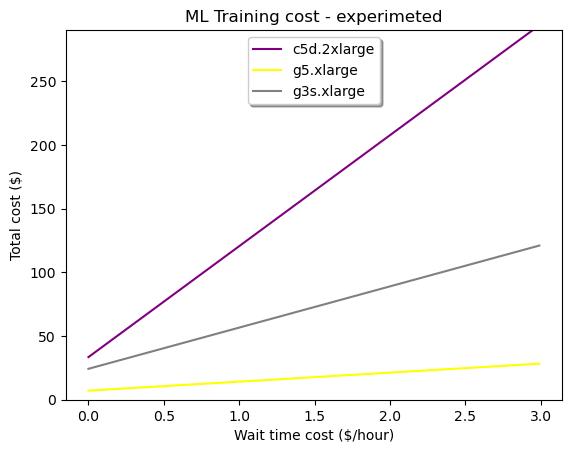

In [37]:
ML_TRAIN_TOTAL_COST_G5 = (ML_training_results.loc["g5.xlarge","EPOCH_COST"]
        +TIME_COST_HOUR*ML_training_results.loc["g5.xlarge","EPOCH_TIME (h)"])*EPOCHS
ML_TRAIN_TOTAL_COST_C5D = (ML_training_results.loc["c5d.2xlarge","EPOCH_COST"]
        +TIME_COST_HOUR*ML_training_results.loc["c5d.2xlarge","EPOCH_TIME (h)"])*EPOCHS
ML_TRAIN_TOTAL_COST_G3S = (ML_training_results.loc["g3s.xlarge","EPOCH_COST"]
        +TIME_COST_HOUR*ML_training_results.loc["g3s.xlarge","EPOCH_TIME (h)"])*EPOCHS

fig, ax = plt.subplots()
ax.plot(TIME_COST_HOUR,ML_TRAIN_TOTAL_COST_C5D, label = "c5d.2xlarge", color= "purple")
ax.plot(TIME_COST_HOUR,ML_TRAIN_TOTAL_COST_G5, label = "g5.xlarge", color= "yellow")
ax.plot(TIME_COST_HOUR,ML_TRAIN_TOTAL_COST_G3S, label = "g3s.xlarge", color= "gray")

legend = ax.legend(loc='upper center', shadow=True)

plt.title('ML Training cost - execution')
plt.xlabel('Wait time cost ($/hour)')
plt.ylabel('Total cost ($)')
plt.ylim(0,290)
plt.savefig("ML_train.png")
plt.show()

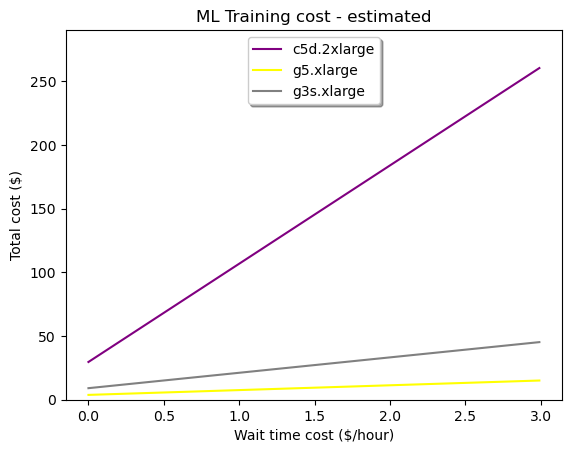

In [38]:
ML_TRAIN_TOTAL_COST_G5_EST = (ML_training_results.loc["g5.xlarge","EPOCH_COST Est"]
        +TIME_COST_HOUR*ML_training_results.loc["g5.xlarge","EPOCH_TIME (h) Est"])*EPOCHS
ML_TRAIN_TOTAL_COST_C5D_EST = (ML_training_results.loc["c5d.2xlarge","EPOCH_COST Est"]
        +TIME_COST_HOUR*ML_training_results.loc["c5d.2xlarge","EPOCH_TIME (h) Est"])*EPOCHS
ML_TRAIN_TOTAL_COST_G3S_EST = (ML_training_results.loc["g3s.xlarge","EPOCH_COST Est"]
        +TIME_COST_HOUR*ML_training_results.loc["g3s.xlarge","EPOCH_TIME (h) Est"])*EPOCHS

fig, ax = plt.subplots()
ax.plot(TIME_COST_HOUR,ML_TRAIN_TOTAL_COST_C5D_EST, label = "c5d.2xlarge", color= "purple")
ax.plot(TIME_COST_HOUR,ML_TRAIN_TOTAL_COST_G5_EST, label = "g5.xlarge", color= "yellow")
ax.plot(TIME_COST_HOUR,ML_TRAIN_TOTAL_COST_G3S_EST, label = "g3s.xlarge", color= "gray")

legend = ax.legend(loc='upper center', shadow=True)

plt.title('ML Training cost - estimation')
plt.xlabel('Wait time cost ($/hour)')
plt.ylabel('Total cost ($)')
plt.savefig("ML_train_estimated.png")
plt.ylim(0,290)
plt.show()

In [39]:
#Real and estimated total costs
round(ML_TRAIN_TOTAL_COST_G5[0],2), round(ML_TRAIN_TOTAL_COST_G5_EST[0],2)

(7.12, 3.79)

In [40]:
#Difference in percentages
round((ML_TRAIN_TOTAL_COST_G5[0]-ML_TRAIN_TOTAL_COST_G5_EST[0])/ML_TRAIN_TOTAL_COST_G5[0],2)

0.47

In [41]:
ML_TRAIN_CHEAPEST = np.full(TIME_COST_HOUR.shape,None)
ML_TRAIN_CHEAPEST_EST = np.full(TIME_COST_HOUR.shape,None)

In [42]:
for i in np.arange(len(ML_TRAIN_CHEAPEST)):
    if (ML_TRAIN_TOTAL_COST_C5D[i] < ML_TRAIN_TOTAL_COST_G5[i]) and (ML_TRAIN_TOTAL_COST_C5D[i] < ML_TRAIN_TOTAL_COST_G3S[i]):
        ML_TRAIN_CHEAPEST[i] = C5D_COLOR
    elif (ML_TRAIN_TOTAL_COST_G3S[i] < ML_TRAIN_TOTAL_COST_C5D[i]) and (ML_TRAIN_TOTAL_COST_G3S[i] < ML_TRAIN_TOTAL_COST_G5[i]):
        ML_TRAIN_CHEAPEST[i] = G53_COLOR
    else:
        ML_TRAIN_CHEAPEST[i] = G5_COLOR

In [43]:
for i in np.arange(len(ML_TRAIN_CHEAPEST_EST)):
    if (ML_TRAIN_TOTAL_COST_C5D_EST[i] < ML_TRAIN_TOTAL_COST_G5_EST[i]) and (ML_TRAIN_TOTAL_COST_C5D_EST[i] < ML_TRAIN_TOTAL_COST_G3S_EST[i]):
        ML_TRAIN_CHEAPEST_EST[i] = C5D_COLOR
    elif (ML_TRAIN_TOTAL_COST_G3S_EST[i] < ML_TRAIN_TOTAL_COST_C5D_EST[i]) and (ML_TRAIN_TOTAL_COST_G3S_EST[i] < ML_TRAIN_TOTAL_COST_G5_EST[i]):
        ML_TRAIN_CHEAPEST_EST[i] = G53_COLOR
    else:
        ML_TRAIN_CHEAPEST_EST[i] = G5_COLOR

In [44]:
indices = np.where(
    (TIME_COST_HOUR == 0.5) | (TIME_COST_HOUR ==1) | (TIME_COST_HOUR == 1.5) | (TIME_COST_HOUR ==2) | (TIME_COST_HOUR ==2.5))

In [47]:
Z=np.stack((DATA_EXTRACT_CHEAPEST.astype(float),DATA_JOINS_CHEAPEST.astype(float),ML_TRAIN_CHEAPEST.astype(float)))

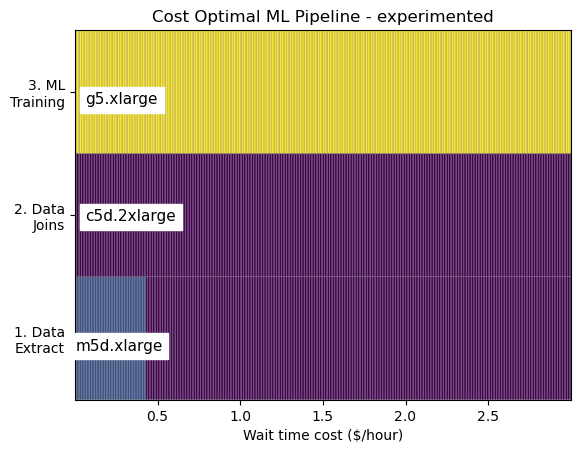

In [48]:
#Z = np.random.rand(3, TIME_COST_HOUR.shape[0])

fig, ax = plt.subplots()

ax.text(0.2,0.4,"m5d.xlarge", color="black", size =11 ,bbox=dict(edgecolor = 'white', facecolor='white'))
ax.text(6.5,1.45,"c5d.2xlarge", color="black", size =11 ,bbox=dict(edgecolor = 'white', facecolor='white'))
ax.text(6.5,2.4,"g5.xlarge", color="black", size =11 ,bbox=dict(edgecolor = 'white', facecolor='white'))

ax.set_yticks([0.5, 1.5, 2.5], labels=['1. Data\nExtract', '2. Data\nJoins', '3. ML\nTraining'])
ax.set_xticks(indices[0], labels=['0.5','1.0','1.5','2.0','2.5'])
ax.set_title("Cost Optimal ML Pipeline - experimented")
ax.set_xlabel("Wait time cost ($/hour)")
c = ax.pcolor(Z,edgecolors='gray',linewidths=0.2)
plt.savefig("summary_results.png")
plt.show()

In [49]:
Z=np.stack((DATA_EXTRACT_CHEAPEST_EST.astype(float),DATA_JOINS_CHEAPEST_EST.astype(float),ML_TRAIN_CHEAPEST_EST.astype(float)))

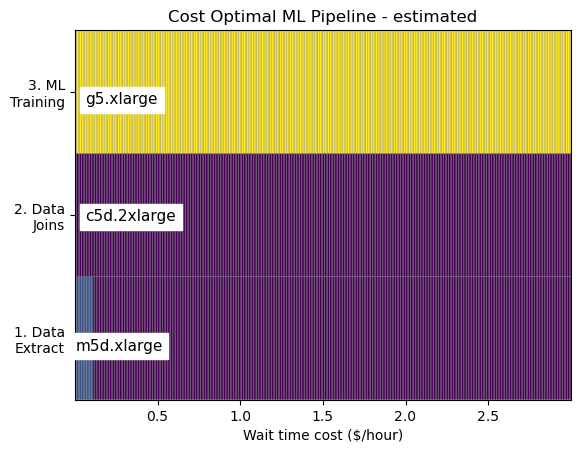

In [50]:
fig, ax = plt.subplots()

ax.text(0.2,0.4,"m5d.xlarge", color="black", size =11 ,bbox=dict(edgecolor = 'white', facecolor='white'))
ax.text(6.5,1.45,"c5d.2xlarge", color="black", size =11 ,bbox=dict(edgecolor = 'white', facecolor='white'))
ax.text(6.5,2.4,"g5.xlarge", color="black", size =11 ,bbox=dict(edgecolor = 'white', facecolor='white'))

ax.set_yticks([0.5, 1.5, 2.5], labels=['1. Data\nExtract', '2. Data\nJoins', '3. ML\nTraining'])
ax.set_xticks(indices[0], labels=['0.5','1.0','1.5','2.0','2.5'])
ax.set_title("Cost Optimal ML Pipeline - estimation")
ax.set_xlabel("Wait time cost ($/hour)")
c = ax.pcolor(Z,edgecolors='gray',linewidths=0.2)
plt.savefig("summary_results_est.png")
plt.show()